# Hochschule Bonn-Rhein-Sieg

# Mathematics for Robotics and Control, WS17

# Assignment 11

### Team members: Vajra Ganeshkumar, Jeeveswaran Kishaan

In [1]:
import numpy as np
import IPython
import matplotlib.pyplot as plt

### Exercise 1: Recursive Bayes filter for robot localisation [60 points]

The goal of the recursive Bayes filter we've seen in class is to estimate the state $X$ of a system at a given time step $n$, which we denote by $X_n$, given a set of motion commands $U$ and measurements $Z$ from time $t=1$ until $t=n$, which we denote by $U_{1:n}$ and $Z_{1:n}$ respectively. To estimate the state, we need to update the so-called *belief distribution* $P(X_n | X_{1:n-1}, U_{1:n}, Z_{1:n})$ - which represents our current belief about the state - and then pick the state that maximises the distribution as a representation of the current state. This principle can be naturally applied to the problem of robot localisation, so this exercise is going to be about implementing a recursive Bayes filter that allows us to localise a robot operating in a grid environment.

As the name suggests, the recursive Bayes filter can be used for localisation by performing a couple of steps recursively:
1. *Motion update*: Once a robot moves, we predict the next state by updating the belief using the equation:
\begin{equation*}
    \tilde{P}(X_n | X_{1:n-1}, U_{1:n}, Z_{1:n-1}) = \sum_{X_{n-1}}{P(X_n | X_{n-1}, U_{n})P(X_{n-1} | X_{1:n-2}, U_{1:n-1}, Z_{1:n-1})}
\end{equation*}
where $P(X_n | X_{n-1}, U_{n})$ is known as a *transition model*, which takes the motion uncertainty into account.
2. *Measurement update*: When the robot makes a measurement, we correct the belief using the equation:
\begin{equation*}
    P(X_n | X_{1:n-1}, U_{1:n}, Z_{1:n}) = \alpha P(Z_n | X_n)\tilde{P}(X_n | X_{1:n-1}, Z_{1:n-1})
\end{equation*}
where $P(Z_n | X_n)$ is known as a *measurement model*.

The quality of the localisation estimate produced by the Bayes filter depends on various factors, such as the motion and measurement noise, as well as the environment configuration itself. It should be noted that we assume that the map of the environment is known when considering the problem of localisation.

The scenario we are going to consider in this exercise is the following: we have a robot that moves in a $10 \times 10$ grid environment, which has obstacles in some of the cells and a set of landmarks in others; the environment is shown in the figure below, where the blue stripes denote obstacles and the orange cells are the ones that contain landmarks:

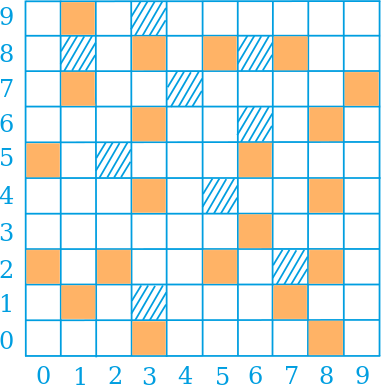

In [2]:
IPython.core.display.Image("images/grid_environment.png", embed=True)

Our robot has a sensor for discovering landmarks, such that a landmark can only be sensed if the robot is in the cell where the landmark is. We assume that the sensor is noisy, so a landmark is correctly sensed $99\%$ of the time; there is also a $1\%$ probability that the sensor returns a measurement even if there is no landmark in a given cell. We assume that the robot moves randomly around the environment - it can only move up, down, to the left, and to the right - such that its motion is also noisy; in particular, the robot only moves to its desired destination with $97\%$ probability, while there is $1\%$ probability that it will end up in any of the three other neighbouring cells. If the robot tries to move to a cell with an obstacle or hits a wall, its position doesn't change; this also means that if the robot tries moving to a free cell and one of the three other neighbouring cells has an obstacle, there is $1\%$ probability that it will stay at the current position.

Your task in this problem is to implement a recursive Bayes filter that takes this information into account and localises the robot under the assumption that we don't know its initial position; this means that the initial belief distribution will be a uniform distribution over the available grid cells.

In [19]:
class RecursiveBayesFilter(object):
    def __init__(self, env, landmark_map, init_belief_distribution, \
                transition_noise, measurement_noise):
        self.env = np.array(env)
        self.landmark_map = np.array(landmark_map)
        self.belief = np.array(init_belief_distribution)
        self.transition_noise = transition_noise
        self.measurement_noise = measurement_noise

    def transition_model(self, current_pos, new_pos, motion_command):
        # considering all the possibilities of which the robot could've come 
        # to the new_pos
        if (current_pos[0] + motion_command[0]) == new_pos[0] and (current_pos[1] \
                                                + motion_command[1]) == new_pos[1]:
            # the pair of current and new position match the motion command
            if (current_pos[0] in range(10) and current_pos[1] in range(10) and \
               (self.env[current_pos[0], current_pos[1]] == 1)):
                # robot coming from a free cell
                return self.belief[current_pos[0], current_pos[1]] * \
                       (1.0 - self.transition_noise)
            elif (current_pos[0]  in range(10) and current_pos[1] in range(10) and \
                  (self.env[current_pos[0], current_pos[1]] == 0)):
                # robot coming from an obstacle, which is impossible
                return 0.0
            else:
                # the bot stays in the current position with probability 0.97
                return self.belief[new_pos[0], new_pos[1]] * \
                                  (1.0 - self.transition_noise)
        else:
            # the current and new position don't match the motion command
            if (current_pos[0] in range(10) and current_pos[1] in range(10) and \
                (self.env[current_pos[0], current_pos[1]] == 1)):
                # robot coming from a free cell
                return self.belief[current_pos[0], current_pos[1]] * \
                       (self.transition_noise / 3.0)
            elif (current_pos[0] in range(10) and current_pos[1] in range(10) \
                  and (self.env[current_pos[0], current_pos[1]] == 0)):
                # robot coming from an obstacle, which is impossible
                return 0.0
            else:
                # the bot stays in the current position with probability 0.01
                return self.belief[new_pos[0], new_pos[1]] * \
                             (self.transition_noise / 3.0)
        
    def measurement_model(self, measurement, pos):
        if self.landmark_map[pos[0], pos[1]] == measurement:
            # if the measurement ensures the position 
            return (1.0 - self.measurement_noise)
        else:
            # if the measurement doesn't ensure the position
            return self.measurement_noise

    def state_update(self, motion_command):
        new_belief = np.zeros_like(self.belief)
        # list of all possible motions
        possible_motions = [[0,1], [1,0], [-1,0], [0,-1]]
        for (x, y), element in np.ndenumerate(self.belief):
            posterior = 0.0
            if self.env[x,y] == 1:
                # considering all the cells which could be the current 
                # position of robot
                for move in possible_motions:
                    new_pos = [x,y]
                    current_pos = [x-move[0], y-move[1]]
                    # calling transition model with every possible pair 
                    # of current and new positions
                    posterior += self.transition_model(current_pos, \
                                               new_pos, motion_command)
                new_belief[x,y] = posterior
        new_belief = new_belief / np.sum(new_belief)
        self.belief = new_belief

    def measurement_update(self, measurement):
        new_belief = np.array(self.belief)
        for (x, y), element in np.ndenumerate(self.belief):
            pos = [x,y]
            # getting the p(z/x) from the measurement model function
            new_belief[x, y] *= self.measurement_model(measurement, pos) 
        new_belief = new_belief / np.sum(new_belief)
        self.belief = new_belief

### Reference : Lab Class exercise and Lecture slides on Bayesian Filtering

### Testing your implementation

You can test your implementation by running the code below, which:
1. creates the environment
2. creates an object of the *RecursiveBayesFilter* class
3. recursively generates motion commands and measurements (taking into account the motion and measurement noise)
4. at each step, calculates the distance between the actual position of the robot and the localisation estimate produced by the filter

Your implementation is most likely correct if the estimate is generally correct; however, don't expect to have a perfect localisation estimate all the time because the environment configuration we are considering is quite complicated and the sensor measurements are not always sufficient for uniquely describing the position of the robot. In addition to that, keep in mind that different runs will produce different results because both the motion and the measurements are randomised. A typical plot of the distance between the real position and the estimate produced by the Bayes filter might look as shown below.

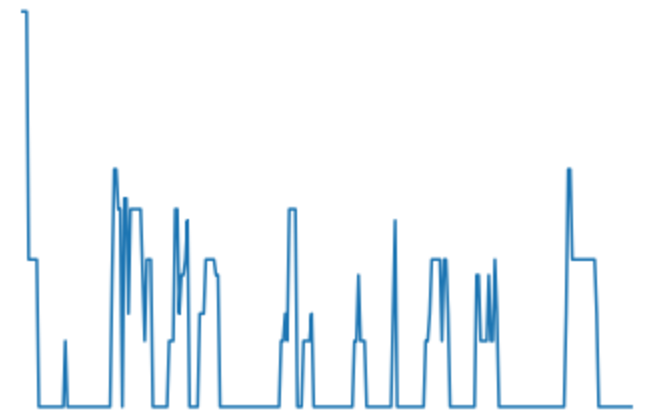

In [20]:
IPython.core.display.Image("images/bayes_filter_estimate_distance.png", embed=True)

The cell below also contains code for visualising the localisation estimate at each time step, but the line that calls the visualisation function is commented out. If you want to visualise the estimate while testing your code, please uncomment the line that calls the *plot_configuration* function.

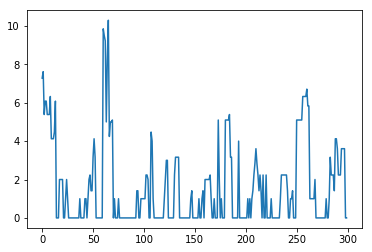

In [25]:
### Bayes filter test code ###

def is_valid_transition(current_pos, motion_command, env_size):
    if current_pos[0] + motion_command[0] >= 0 and \
    current_pos[0] + motion_command[0] < env_size[0] and \
    current_pos[1] + motion_command[1] >= 0 and \
    current_pos[1] + motion_command[1] < env_size[1] and \
    env[actual_pos[0] + motion_command[0], \
        actual_pos[1] + motion_command[1]] != 0:
        return True

    return False

def generate_motion_command():
    motion_command = np.array([0, 0], dtype=int)
    while (motion_command[0] == motion_command[1]) or \
    (motion_command[0] + motion_command[1]) == 0:
        motion_command[0] = np.random.randint(-1, 2)
        motion_command[1] = np.random.randint(-1, 2)
    return motion_command

def plot_configuration(env, landmark_map, actual_pos, max_idx):
    IPython.display.clear_output(wait=True)
    plt.clf()

    for i in xrange(env.shape[0]):
        for j in xrange(env.shape[1]):
            if env[i, j] == 0:
                plt.plot(i, j, 'bs')
            elif landmark_map[i, j] == 1:
                plt.plot(i, j, 'kD')

    plt.plot(actual_pos[0], actual_pos[1], 'ro')
    plt.plot(max_idx[0], max_idx[1], 'r*')
    plt.xlim([-1, 10])
    plt.ylim([-1, 10])
    IPython.display.display(fig)

env = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],\
               [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],\
               [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],\
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],\
               [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],\
               [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],\
               [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],\
               [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],\
               [1, 0, 1, 1, 1, 1, 0, 1, 1, 1],\
               [1, 1, 1, 0, 1, 1, 1, 1, 1, 1]], dtype=int)

landmark_map = np.array([[0, 0, 0, 1, 0, 0, 0, 0, 1, 0],\
                        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],\
                        [1, 0, 1, 0, 0, 1, 0, 0, 1, 0],\
                        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],\
                        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],\
                        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],\
                        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],\
                        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1],\
                        [0, 0, 0, 1, 0, 1, 0, 1, 0, 0],\
                        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int)

belief_distribution = np.zeros((10, 10))
free_cells_idx = np.where(env == 1)
belief_distribution[free_cells_idx[0], free_cells_idx[1]] = \
1. / len(free_cells_idx[0])
transition_noise = 0.03
measurement_noise = 0.01

bayes_filter = RecursiveBayesFilter(env, landmark_map, belief_distribution, \
                                   transition_noise, measurement_noise)
number_of_steps = 300

actual_pos = np.array([np.random.randint(0, 10), \
                       np.random.randint(0, 10)], dtype=int)
while env[actual_pos[0], actual_pos[1]] == 0:
    actual_pos[0] = np.random.randint(0, 10)
    actual_pos[1] = np.random.randint(0, 10)
distances = np.zeros(number_of_steps)

fig = plt.figure(1)
for n in xrange(number_of_steps):
    motion_command = generate_motion_command()
    if is_valid_transition(actual_pos, motion_command, env.shape):
        r = np.random.rand()
        if r < (1 - transition_noise):
            actual_pos[0] = actual_pos[0] + motion_command[0]
            actual_pos[1] = actual_pos[1] + motion_command[1]
        else:
            noisy_motion = np.array(motion_command)
            while noisy_motion[0] == motion_command[0] and \
            noisy_motion[1] == motion_command[1]:
                noisy_motion = generate_motion_command()
            if is_valid_transition(actual_pos, noisy_motion, env.shape):
                actual_pos[0] = actual_pos[0] + noisy_motion[0]
                actual_pos[1] = actual_pos[1] + noisy_motion[1]
    else:
        r = np.random.rand()
        if r > (1 - transition_noise):
            noisy_motion = np.array(motion_command)
            while noisy_motion[0] == motion_command[0] and \
            noisy_motion[1] == motion_command[1]:
                noisy_motion = generate_motion_command()
            if is_valid_transition(actual_pos, noisy_motion, env.shape):
                actual_pos[0] = actual_pos[0] + noisy_motion[0]
                actual_pos[1] = actual_pos[1] + noisy_motion[1]
    bayes_filter.state_update(motion_command)

    measurement = landmark_map[actual_pos[0], actual_pos[1]]
    r = np.random.rand()
    if r > (1 - measurement_noise):
        measurement = 1 - measurement

    bayes_filter.measurement_update(measurement)
    max_idx = np.unravel_index(bayes_filter.belief.argmax(), \
                               bayes_filter.belief.shape)
    distances[n] = np.linalg.norm(np.array(actual_pos) - np.array(max_idx))

#     plot_configuration(env, landmark_map, actual_pos, max_idx)
plt.plot(distances)
plt.show()

### Exercise 2: Joint probability distributions [20 points]

In this exercise, you will write a very simple Python library for manipulating joint probability distributions of two discrete random variables, such that the waiter youBot from the lab class will be our test case. Given a joint distribution, we want our library to be able to:

* Find the probability mass functions of the random variables.
* Check if the variables are independent.
* Calculate the conditional PMF of one of the random variables given an observed value for the other variable.
* Calculate the conditional expectation of one of the random variables given an observed value for the other variable.
* Calculate the covariance of the random variables.

In other words, we want the library to be able to find answers to all questions in the youBot waiter problem.

Define your library functions in the class *DiscreteJointDistribution*, whose interface is given below. Verify that your functions are working correctly by running the test cases below and making sure that none of the assertions fail.

In [28]:
class DiscreteJointDistribution(object):
    def __init__(self, variable_names, var1_values, var2_values, distribution):
        self.variable_names = list(variable_names)
        self.var1_values = list(var1_values)
        self.var2_values = list(var2_values)
        self.distribution = np.array(distribution)

    def find_pmf(self, variable_name):
        index = [i for i in range(len(self.variable_names)) if self.variable_names[i] \
                 == variable_name][0]
        pmf = np.zeros(np.shape(self.distribution)[index])
        if index == 0:
            # variable is x
            for i in range(len(self.var1_values)):
                # sum over rows
                pmf = self.distribution.sum(axis=1)
        else:
            # variable is y
            for i in range(len(self.var2_values)):
                # sum over columns
                pmf = self.distribution.sum(axis=0)
        return pmf

    def variables_independent(self):
        # independent if P(X,Y) = P(X) * P(Y)
        var1_sum = self.find_pmf('X')
        var2_sum = self.find_pmf('Y')
        for i in range(np.shape(self.distribution)[0]):
            for j in range(np.shape(self.distribution)[1]):
                if self.distribution[i][j] != (var1_sum[i] * var2_sum[j]):
                    return False
        return True

    def conditional_pmf(self, observed_variable_name, observed_value):
        index = [i for i in range(len(self.variable_names)) if \
                 self.variable_names[i] == observed_variable_name][0]
        if index == 0:
            # observed variable is X, conditional probability given by P(X,Y)/P(X)
            index_obs = [i for i in range(len(self.var1_values)) if \
                         self.var1_values[i] == observed_value][0]
            cond_pmf = np.zeros(np.shape(self.distribution)[1])
            for i in range(len(cond_pmf)):
                cond_pmf[i] = self.distribution[index_obs][i] / \
                               float(self.find_pmf('X')[index_obs])
        else:
            # observed variable is Y, conditional probability given by P(X,Y)/P(Y)
            index_obs = [i for i in range(len(self.var2_values)) if \
                         self.var2_values[i] == observed_value][0]
            cond_pmf = np.zeros(np.shape(self.distribution)[0])
            for i in range(len(cond_pmf)):
                cond_pmf[i] = self.distribution[i][index_obs] / \
                float(self.find_pmf('Y')[index_obs])
        return cond_pmf

    def conditional_expectation(self, observed_variable_name, observed_value):
        cond_exp = 0.0
        index = [i for i in range(len(self.variable_names)) if self.variable_names[i] \
                 == observed_variable_name][0]
        if index == 0:
            # observed variable is X, conditional pmf is given by sum (Y * P(Y/X)
            c_pdf = self.conditional_pmf(observed_variable_name, observed_value)
            for i in range(len(c_pdf)):
                cond_exp += float(self.var2_values[i]) * float(c_pdf[i])
        else:
            # observed variable is Y, conditional pmf is given by sum (X * P(X/Y)
            c_pdf = self.conditional_pmf(observed_variable_name, observed_value)
            for i in range(len(c_pdf)):
                cond_exp += self.var1_values[i] * c_pdf[i]
        return cond_exp

    def covariance(self):
        ### write your code here ###
        cov = 0.0
        exp_X = 0.0 # E[X]
        exp_Y = 0.0 # E[Y]
        
        # covariance given by [sum_x sum_y (X - E[X]) (Y - E[Y]) * P(X,Y)]
        pmf_X = self.find_pmf('X')
        pmf_Y = self.find_pmf('Y')
        for i in range(len(self.var1_values)):
            exp_X += float(self.var1_values[i]) * float(pmf_X[i])
        for i in range(len(self.var2_values)):
            exp_Y += float(self.var2_values[i]) * float(pmf_Y[i])
        for i in range(np.shape(self.distribution)[0]):
            for j in range(np.shape(self.distribution)[1]):
                cov += (float(self.var1_values[i]) - exp_X) * \
                       (float(self.var2_values[j]) - exp_Y) * \
                        float(self.distribution[i][j]) 
        return cov

variable_names = ['X', 'Y']
x_values = ['0.01', '0.05', '0.1', '0.2']
y_values = ['0', '1', '2']
distribution = np.array([[6./28., 1./28., 0.], [2./28., 2./28., 1./28.], \
                         [1./28., 4./28., 3./28.], [0., 2./28., 6./28.]])
joint_distribution = DiscreteJointDistribution(variable_names, x_values, \
                                               y_values, distribution)

# pmfs test case
x_pmf = joint_distribution.find_pmf('X')
y_pmf = joint_distribution.find_pmf('Y')
assert np.all(np.abs(x_pmf - np.array([7./28., 5./28., 8./28., 8./28.])) < 1e-5)
assert np.all(np.abs(y_pmf - np.array([9./28., 9./28., 10./28.])) < 1e-5)

# variable independence test case
assert joint_distribution.variables_independent() == False

# conditional pmf test case
conditional_pmf = joint_distribution.conditional_pmf('X', '0.01')
assert np.all(np.abs(conditional_pmf - np.array([6./7., 1./7., 0.])) < 1e-5)

# conditional expectation test case
conditional_expectation = joint_distribution.conditional_expectation('X', '0.01')
assert abs(conditional_expectation - 1./7.) < 1e-5

# covariance test case
covariance = joint_distribution.covariance()
assert abs(covariance - 0.04) < 1e-2

### Reference : Lab class exercise 